In [ ]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/FakeNewsModel 1.0'  
NEW_DATA = '/content/drive/MyDrive/Datasets/IFND.csv'  
SAVE_PATH = '/content/drive/MyDrive/FakeNewsModel 1.1'  

In [ ]:
df = pd.read_csv(NEW_DATA)
df = df.dropna()  

In [ ]:
df['label'] = df['label'].str.lower().str.strip()  
df = df[df['label'].isin(['true', 'fake'])]  
df['label'] = df['label'].map({'true': 0, 'fake': 1})  

print("\nLabel Distribution After Cleaning:")
print(df['label'].value_counts())


Label Distribution After Cleaning:
label
0    37800
1    18914
Name: count, dtype: int64


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42
)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_PATH)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/FakeNewsModel 1.0.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Retraining model...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Retraining model...
Epoch 1/3
2836/2836 [==============================] - 446s 148ms/step - loss: 0.1367 - accuracy: 0.9577 - val_loss: 0.0921 - val_accuracy: 0.9698
Epoch 2/3
2836/2836 [==============================] - 415s 146ms/step - loss: 0.0729 - accuracy: 0.9770 - val_loss: 0.0947 - val_accuracy: 0.9697
Epoch 3/3
2836/2836 [==============================] - 408s 144ms/step - loss: 0.0481 - accuracy: 0.9829 - val_loss: 0.1086 - val_accuracy: 0.9697


Plot saved to: /content/drive/MyDrive/accuracy_plot.png


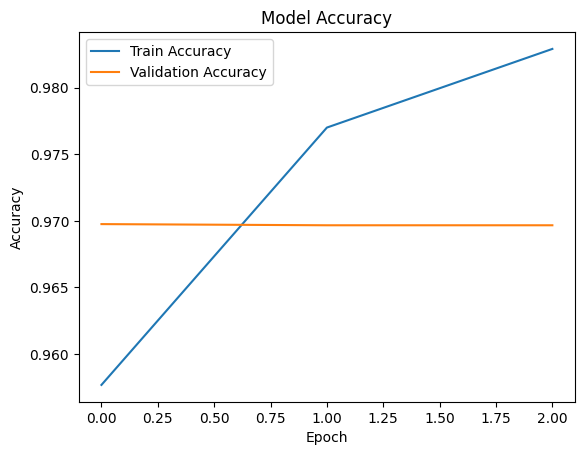

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

save_path = '/content/drive/MyDrive/accuracy_plot.png'  
plt.savefig(save_path, dpi=300, bbox_inches='tight')  
print(f"Plot saved to: {save_path}")

plt.show()

In [19]:
plt.savefig('/content/drive/MyDrive/training_metrics.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

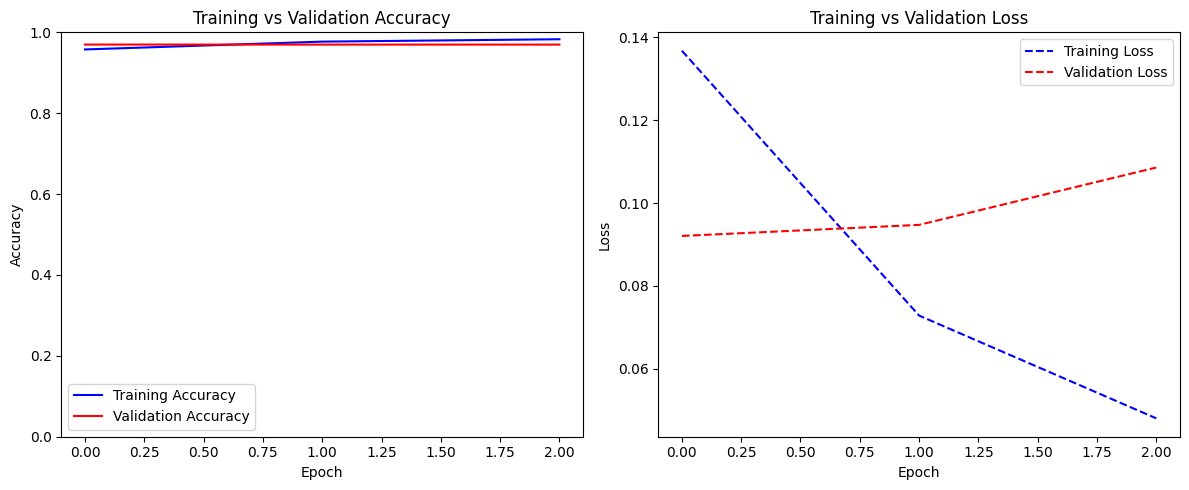

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])  
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b--', label='Training Loss')
plt.plot(history.history['val_loss'], 'r--', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)
print(f"Model saved to {SAVE_PATH}")

Model saved to /content/drive/MyDrive/FakeNewsModel 1.1


In [24]:
loss, accuracy = model.evaluate(val_dataset)
print(f"\nValidation Accuracy: {accuracy:.2%}")
print(f"Validation Loss: {loss:.4f}")

709/709 [==============================] - 34s 49ms/step - loss: 0.1086 - accuracy: 0.9697

Validation Accuracy: 96.97%
Validation Loss: 0.1086
